In [3]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']
import seaborn as sns
%matplotlib inline

# Linear SVM

The canonical Support Vector Machine is the linear one.  Assume we have two groups labeled by $y = \pm 1$.  Then we are trying to find the line $\beta$ such that $X \beta + \beta_0$ maximially separates the points in our two classes:

![SVM Diagram from Hastie et al's The Elements of Statistical Learning](../images/svm3.png)

If the two classes can be separated by a linear hyperplane (picture on the left), we want to maximize the **margin** $M$ of the **boundary region**.  A little bit of math can show us that finding the largest separation is actually solved by the minimization problem

$$
\min_{\beta, \beta_0} \|\beta\| \\
\mbox{subject to } y_j (X_{j\cdot} \cdot \beta + \beta_0) \ge 1 \quad \mbox{for } j = 1,\ldots,N
$$

The picture and the equation are equivalent: in the picture we are setting the margin to be $M$ and finding the largest margin possible.  In the equation, we are setting the margin to be $1$ and finding the smallest $\beta$ that will make that true.  So $\beta$ and $M$ are related through $\| \beta \| = \frac{1}{M}$.  If the two classes cannot be separated (picture on the right), we will have to add a forgiveness terms $\xi$,

$$
\min_{\beta, \beta_0} \|\beta\| \\
\mbox{subject to } \left\{ \begin{array} {cl} 
 y_j (X_{j\cdot} \cdot \beta + \beta_0) \ge (1-\xi_j) & \mbox{for } j = 1,\ldots,N \\
 \xi_j \ge 0 & \mbox{for } j = 1,\ldots,N \\
 \sum_j \xi_j \le C
\end{array}\right.
$$

for some constant $C$.  The constant $C$ is an important tradeoff.  It corresponds to the total "forgiveness budget" (see the last constraint).  The larger $C$, the forgiveness we have and the wider the margin $M$ can be.  We can rewrite the constrained optimization problem as the primal Lagrangian function with Lagrange multipliers $\alpha_j \ge 0$, $\mu_j \ge 0$, and $\gamma \ge 0$,  for each of our three constraints:

$$ L_P(\gamma) = \min_{\beta, \beta_0, \xi} \max_{\alpha, \mu} \frac{1}{2} \| \beta \|^2 - \sum_j \alpha_j \left[y_j (X_{j \cdot} \cdot \beta + \beta_0 - (1-\xi_j)\right] - \sum_j \mu_j \xi_j  + \gamma \sum_j \xi_j$$

There is a one-to-one correspondence between $\gamma$ and $C$.  By taking first order conditions, first-order conditions, the dual Lagrangian problem can be formulated as

$$
L_D(\gamma) = \max_{\alpha} \sum_j \alpha_j - \frac{1}{2} \sum_{j, j'} \alpha_j \alpha_{j'} y_j y_{j'} X_{j \cdot} \cdot X_{j' \cdot} \,. \\
\mbox{subject to } \left\{ \begin{array} {cl} 
0 = \sum_j \alpha_j y_j \\
0 \le \alpha_j \le \gamma & \mbox{for } j = 1,\ldots,N
\end{array}\right.
$$

This is now a reasonably straightforward quadratic programming problem.  It is solved via [Sequential Minimization Optimization](https://en.wikipedia.org/wiki/Sequential_minimal_optimization).  Once we have solved this problem for $\alpha$, we can easily work out the coefficients from

$$ \beta = \sum_j \alpha_j y_j X_{j \cdot} $$

**Key takeaways**:
1. Critically, only points inside the margin or on the wrong side of the margin ($j$ for which $\xi_j > 0$) affect the SVM (see the picture).  This is intuitively clear from the picture.  In the dual form, this is because $\alpha_j$ is the Lagrangian constraint corresponding to $y_j (X_{j\cdot} \cdot \beta + \beta_0) \ge (1-\xi_j)$ and Complementary Slackness shows tells us that $\alpha_j > 0$ is non-zero only when the constraint is binding ($y_j (X_{j\cdot} \cdot \beta + \beta_0) = (1-\xi_j)$), i.e. we're in the boundary region.  This is meaning the **Support Vector** in "SVM": only the vectors in the boundary-the **Support Vectors**-contribute to the solution.
1. $C$ or $\gamma$ give a trade-off between the amount of forgiveness and the size of the margin or boundary region.  Hence, it controls how many points affect the SVM (based on the distance from the boundary).

Below, we plot out a simple two-class linear SVM on some synthetic data

(-0.5, 1.0)

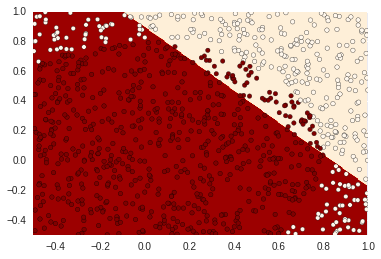

In [4]:
import numpy as np
from matplotlib import pylab as plt
from sklearn import svm

x_min = -.5
x_max = 1.

# we only take the first two features for visualization
X = np.random.uniform(x_min, x_max, size=[1000,2])
y = np.linalg.norm(X, axis=1) < .8

#set our error margin
C=1
# linear kernel classifier
clf = svm.SVC(kernel='linear', C=C).fit(X, y)

# create a mesh to plot for clf values
h = .005  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(x_min, x_max, h))

# predicted values
zz = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, zz, cmap=plt.cm.OrRd)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.OrRd)
plt.xlim([x_min,x_max])
plt.ylim([x_min,x_max])

# Non-linear SVM

What if we don't believe that our data can be cleanly split by a linear hyperplane?  The common way to incorporate non-linear features is to have a non-linear function $h(X_{j\cdot})$ (possibly to a higher-dimensional feature space with dimension $p'$ where $p' \ge p$) and to train on that space.  One intuition is that there's a higher-dimensional space in which the data is has a linear separation and $h$ gives a non-linear mapping into that space.

## Kernel Trick

The **Kernel Trick** in SVM tells us that rather than directly computing the (potentially very large) vectors $h(X_{j \cdot})$, we can just modify the Kernel.  If we use the transformed data $h(X_{j \cdot})$, the dual Lagrangian would be

$$ \max_{\alpha} \sum_j \alpha_j - \frac{1}{2} \sum_j \sum_{j'} \alpha_j \alpha_{j'} y_j y_{j'} h(X_{j \cdot}) \cdot h(X_{j' \cdot}) $$

We can rewrite

$$h(X_{j \cdot}) \cdot h(X_{j' \cdot})  = K(X_{j \cdot}, X_{j' \cdot})$$ 

for some non-linear Kernel $K$.  Our problem then becomes,

$$ \max_{\alpha} \sum_j \alpha_j - \frac{1}{2} \sum_j \sum_{j'} \alpha_j \alpha_{j'} y_j y_{j'} K(X_{j \cdot}, X_{j' \cdot}) $$

There's a one-to-one correspondence between Kernel functions and functions $h$ (although $h$'s range may be infinite dimensional).  Some common Kernels include

<table>
<tr>
<th>Kernel</th>
<th>$K(x,x')$</th>
<th>Scikit `kernel` parameter</th>
</tr>

<tr>
<td>Linear Kernel</td>
<td>$x \cdot x'$</td>
<td>`kernel='linear'`</td>
</tr>

<tr>
<td>$d$-th Degree Polynomial</td>
<td>$(r + c x \cdot x')^d$</td>
<td>`kernel='poly'`</td>
</tr>

<tr>
<td>Radial Kernel</td>
<td>$ \exp(- c \|x - x' \|^2) $</td>
<td>`kernel='rbf'`</td>
</tr>

<tr>
<td>Neural Network Kernel</td>
<td>$\tanh(c x \cdot x' + r)$</td>
<td>`kernel='sigmoid'`</td>
</tr>
</table>

The benefit of using a Kernel is that we don't have to compute a very high-dimensional (possibly infinite-dimensional) $h$.  All that complexity is just wrapped into the kernel $K$.

For more information on which parameters to pass the kernel, checkout [the Scikit documentation](http://scikit-learn.org/stable/modules/svm.html#svm-kernels).

**Questions**:
1. Given a trained SVM model, how would you make predictions?  Are you able to compute the values for $\beta$?.
1. How does the memory and time scale with $n$, the number of samples, and $p$, the number of features for each kernel $K$?
1. How might we reduce the computation time if one class contains the majority of samples?
1. What happens if each of the features is on a very different scale?  How could you correct for this?
1. Which of these kernels would benefit from subtracting the mean of each feature fom the data?
1. Modify the above example code to use non-linear kernels and examine what the decision boundaries look like.

# Multi-class SVM

To do multiclass SVM, recall that there are generally two strategies, One-verus-One, and One-versus-All.  [Scikit uses One-versus-One (sometimes called All-versus-All strategy)](http://scikit-learn.org/0.11/modules/multiclass.html).  If $f_{ij}$ is the classifier value where $i$ is a positive label ($y=1$) and $j$ is a negative label ($y=-1$), then we choose
$$ \mbox{argmax}_i \sum_{j \neq i} f_{ij}$$

**Question**:
1. Why would you choose One-versus-One or One-versus-All?  (One-versus-All requires more memory and everyone claims SVM is super-linear in memory so we're willing to run more simulations).
1. Can you improve the accuracy by taking some of the steps outlined above?
1. Modify the above code to do the full multi-class SVM (`SVC` automatically does multiple classes, you just have to feed in all the data).

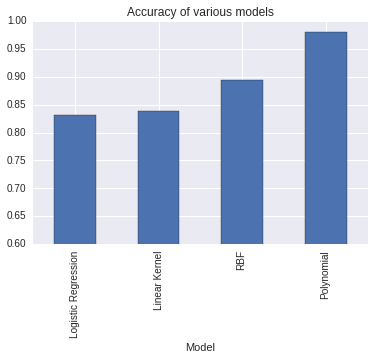

In [5]:
# Sample code to test SVM Classification

from sklearn import svm, linear_model, cross_validation, metrics, random_projection
import pandas as pd

cv = cross_validation.ShuffleSplit(len(y), n_iter=3, test_size=0.25, random_state=42)
C = 1.0

models = [
    ("Logistic Regression", linear_model.LogisticRegression()),
    ("Linear Kernel", svm.SVC(kernel='linear', C=C)),
    ("RBF", svm.SVC(kernel='rbf', gamma=1e-1, C=C)),
    ("Polynomial", svm.SVC(kernel='poly', degree=2))
]

pd.DataFrame([
    (name, cross_validation.cross_val_score(clf, X, y, scoring='accuracy', cv=cv).mean()) for name, clf in models
], columns=["Model", "MSE"]).plot(x="Model", y="MSE", kind="bar", title="Accuracy of various models", ylim=[.6,1.])

## Approximating Kernels

The problem with the Kernel trick is that the memory required for $K$ is $O(n^2)$ and this can be both slow to compute over and expensive memorywise.  Instead, we might choose to transform our data via an approximation $\tilde h$ of the transformation function $h$.  For example, Scikit's `kernel_approximation.Nystroem` provides transformations that approximate each of the non-linear kernels.  Once you have the transformed features, you can pass them to `svm.LinearSVC` class to compute a linear support vector machine.

For more information [Kernel Approximation](http://scikit-learn.org/stable/modules/kernel_approximation.html)

**Exercise**: Load the MNIST Digits dataset.  This is a dataset of handwritten digits 0 - 9 that is used as a canonical training example:

```
digits = datasets.fetch_mldata('mnist-original')
X = digits.data
y = digits.target
```

1. Try to build build a classifier using `svm.SVC` with a non-linear Kernel.  It will just take a long time ...
1. Use `kernel_approximation.Nystroem` and `svm.LinearSVC` chained together via `pipeline.Pipeline` to build a tractable classifier.  Use grid_search to find optimal parameters.  *Hint:* to build up the learner, first restrict the number of classes and the number of examples and then slowly lift those restricitons.

# Support Vector Regression

Support vector machines are also sometimes used to solve regression problems.  In regression, $y$ takes on real values instead of just $\pm 1$.  In the classification case, we penalized the term for being either inside or on the *wrong* side of the margin (**Hinge Loss**).  In regression, we want to penalize for being too far away from the predicted value, regardless of whether you are above or below the margin  (**Well Loss**).  Below, we give a plot of the two:

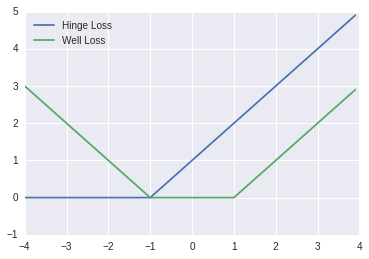

In [6]:
# Plot of the two loss funcitons

from matplotlib import pyplot as plt

def hinge_loss(x):
    return np.maximum(0, x+1.)

def well_loss(x):
    return np.maximum(0, np.abs(x)-1.)

x = np.arange(-4, 4, .1)
plt.plot(x, hinge_loss(x), label="Hinge Loss")
plt.plot(x, well_loss(x), label="Well Loss")
plt.ylim([-1, 5])
plt.legend(loc="upper left")
plt.show()

### Mathematics of SVM Loss

$$
L_P = \min_{\beta, \beta_0} \|\beta\| \\
\mbox{subject to } \left\{ \begin{array} {cl} 
 y_j - X_{j\cdot} \cdot \beta - \beta_0 \le \epsilon + \xi_j & \mbox{for } j = 1,\ldots,N \\
 X_{j\cdot} \cdot \beta + \beta_0 - y_j \le \epsilon + \xi_j^* & \mbox{for } j = 1,\ldots,N \\
 \xi_j \ge 0 & \mbox{for } j = 1,\ldots,N \\
 \xi_j^* \ge 0 & \mbox{for } j = 1,\ldots,N \\
 \sum_j \xi_j + \sum_j \xi_j^* \le C
\end{array}\right.
$$

We can perform a similar calculations to incorporate the Kernel for a new feature map $h$ and real a dual quadratic programming problem.  [Here's a simple article that gives some of the details](http://alex.smola.org/papers/2003/SmoSch03b.pdf).  

$$
L_D(\gamma) = \max_{\alpha} \sum_j y_j (\alpha_j - \alpha_j^*) - \epsilon \sum_j (\alpha_j - \alpha_j^*) - \frac{1}{2} \sum_{j, j'} (\alpha_j - \alpha_j^*) (\alpha_{j'} - \alpha_{j'}^*) K(X_{j \cdot}, X_{j' \cdot}) \,. \\
\mbox{subject to } \left\{ \begin{array} {cl} 
0 = \sum_j (\alpha_j -\alpha_j^*) \\
0 \le \alpha_j \le \gamma & \mbox{for } j = 1,\ldots,N \\
0 \le \alpha_j^* \le \gamma & \mbox{for } j = 1,\ldots,N
\end{array}\right.
$$

where $\alpha_j$ and $\alpha_j^*$ is the dual for $\xi_j$ and $\xi_j^*$.  The weights are given by
$$ \beta = \sum_j (\alpha_j - \alpha_j^*) h(X_{j\cdot})\,. $$

**Question**:
1. Can you write prediction function $f(x)$ in terms of the kernel $K$?

## Application: Outlier Detection

A classic application of SVM is Outlier Detection, which is actually an Unsupervised Learning technique.  The reason it is unsupervised is that one usually has data for "normal" times (**inliers**) but not data for "abnormal" times (**outliers**).  For exmaple, you might be looking at server logs for either abnormally high activity that might indicate security breaches or a failure in your code.  One doesn't really understand what those failure modes are *a priori*.  What you do have is a lot of log data for when the server is behaving normally.

There's a well-known modification to a two-class SVM with a Radial Kernel turning it into a *single-class* SVM by Schölkopf.  Mathematically, it is expressed as

$$
\min_{\beta, \xi, \rho} \frac{1}{2} \|\beta\|^2 + \frac{1}{\nu n}\sum_{j=1}^n \xi_j - \rho \\
\mbox{subject to } \left\{ \begin{array} {cl} 
 h(X_{j\cdot}) \cdot \beta \ge \rho -\xi_j & \mbox{for } j = 1,\ldots,N \\
 \xi_j \ge 0 & \mbox{for } j = 1,\ldots,N
\end{array}\right.
$$

Notice that we are maximizing the value of $\rho$ and that $\rho$ forms a lower bound for $h(X_{j\cdot}) \cdot \beta$ in our constraint.  Hence, we are pushing the points away from the origin in the transformed feature space (of course, there is the usual forgiveness in terms of $\xi$'s).  Hence, instead of penalizing for being on the "wrong" side of the margin for a two-sided problem, we try to push the transformed features as far from the origin as possible.  In the original feature space, this creates a region near the training points which are considered "regular".  You can read more about this in the [Scikit Documentation](http://scikit-learn.org/stable/modules/outlier_detection.html).

Observe that there is a parameter $\nu$ that needs to be set.  This number sets both
1. An upper bound on the fraction of training errors - training examples eroneously labeled as outliers.
1. A lower bound of the fraction of support vectors - number of non-zero $\xi$'s or $\alpha$'s.

$\nu$ has to be set by the modeller and controls the number of false positives (training examples eroneously) and false negatives (although it is hard to know when a false negative occurs without training data).

**Question** Why are these two notions equivalent?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# Generate train data
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
# Generate some regular novel observations
X = 0.3 * np.random.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# Generate some abnormal novel observations
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='orange')

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2, c],
           ["learned frontier", "training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; "
    "errors novel abnormal: %d/40"
    % (n_error_train, n_error_test, n_error_outliers))
plt.show()

# Spoilers

In [ ]:
from sklearn import svm, datasets, cross_validation, kernel_approximation, pipeline, preprocessing, random_projection
    
digits = datasets.fetch_mldata('mnist-original')
X = digits.data
y = digits.target

X = X[y < 4]
y = y[y < 4]

N_SAMPLE=4000

# shuffle the data, it'
np.random.seed(42)
indices = np.arange(len(y))
np.random.shuffle(indices)
X = np.array(X[indices[:N_SAMPLE], :], dtype=float)
y = y[indices[:N_SAMPLE]]

model = pipeline.Pipeline([
    ("Kernel Approximation", kernel_approximation.Nystroem(kernel='poly', gamma=1e-1, degree=2)),
    ("Linear SVC", svm.LinearSVC(C=1e1))
])

cv = cross_validation.KFold(len(y), n_folds=5)
cross_validation.cross_val_score(model, X, y, scoring='accuracy', cv=cv).mean()

*Copyright &copy; 2014 The Data Incubator.  All rights reserved.*

# Spoilers

1. (A trained model are simply the values $\alpha$.  Here's a subtle trick: in a linear model, predicting the values of a linear SVM comes from $x \cdot \beta = \sum_{\alpha_j} y_j X_{j \cdot} \cdot x$.  For a nonlinear SVM, this can be generalized to $\sum_{\alpha_j} y_j K(X_{j \cdot}, x)$
1. (According to the Scikit documentation, this takes [between $O(pn^2)$ and $O(pn^3)$ time](http://scikit-learn.org/stable/modules/svm.html#complexity).  It's easy to see the latter (think about the cost of computing the objective function).
1. Downsampling the more frequently occuring class and increase its `weight` accordingly
1. For each of the kernels, $c$ determines a characteristic scale-length.  Look at the distribution of $x \cdot x'$ or $\|x - x'\|^2$ in your data and choose $c$ roughly as the inverse standard deviation.
1. All the ones that involve an inner product, not the one that involves the difference of features.  Note that $r$ can be aliased to the mean.

*Copyright &copy; 2014 The Data Incubator.  All rights reserved.*